#  <span style="color:orange">Final Project</span>

In [1]:
from pycaret.utils import version
version()

'2.2.1'

# 0.0 Configurar MLFlow

In [2]:
import mlflow
import os

# you can set your tracking server URI programmatically:
mlflow.set_tracking_uri('https://mlflow-aie3.ai.spglobal.com/')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'https://minio-aie3.ai.spglobal.com/'
os.environ['LOGNAME'] = 'oswaldo'

# 1.0 Importar datos de entrenamiento

In [3]:
import pandas as pd
dataset = pd.read_csv("training5.csv")

/Users/oswaldo_gomez/Library/Caches/pypoetry/virtualenvs/time-series-CSagJmyP-py3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
dataset.dropna(inplace=True)

In [5]:
#check the shape of data
dataset.shape

/Users/oswaldo_gomez/Library/Caches/pypoetry/virtualenvs/time-series-CSagJmyP-py3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(82, 24)

In [6]:
dataset['Points'].describe()

count     82.000000
mean     100.341463
std       63.173916
min       14.000000
25%       44.250000
50%       89.500000
75%      148.750000
max      278.000000
Name: Points, dtype: float64

<AxesSubplot:>

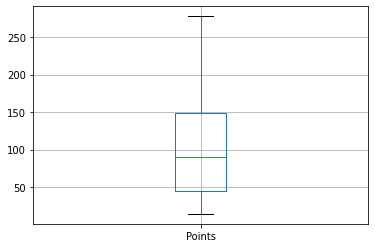

In [7]:
dataset.boxplot(column=['Points'])

## Convertimos la columna de punto de numérica a categórica, con dos categorías. Bueno y Malo. 

### Malo se define entre el valor mínimo teórico y la media. Bueno es entre la media y el valor máximo observado

In [8]:
bins=[0,89,278]
names=['Bad','Good']
dataset['Points_range']=pd.cut(dataset['Points'],bins,labels=names)

/Users/oswaldo_gomez/Library/Caches/pypoetry/virtualenvs/time-series-CSagJmyP-py3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
dataset.sort_values(by='Points_range')

,duration,key,loudness,mode,tempo,artist_hotttnesss,end_of_fade_in,start_of_fade_out,mode_confidence,key_confidence,...,energy,speechiness,acousticness,instrumentalness,liveness,valence,duration_ms,Points,Country,Points_range
0,219.96263,7,-6.869,1,129.991,0.00,0.00000,207.69089,0.755,0.954,...,0.870,0.0456,0.000592,0.82700,0.1620,0.175,219963,45.0,Belgium,Bad
42,209.26694,1,-3.828,1,124.843,0.01,0.58054,204.60263,0.790,0.617,...,0.809,0.0384,0.546000,0.00000,0.1230,0.423,209267,34.0,Italy,Bad
43,173.46613,6,-5.819,1,139.682,0.29,0.00000,168.33305,0.678,0.742,...,0.529,0.0292,0.205000,0.00000,0.0927,0.386,173466,35.0,Netherlands,Bad
44,244.20000,10,-3.871,1,91.996,0.24,0.40685,240.97668,0.430,0.470,...,0.833,0.0310,0.076500,0.00000,0.2390,0.519,244200,64.0,Australia,Bad
45,179.00000,11,-7.907,0,86.175,0.01,0.45274,173.83038,0.718,0.659,...,0.442,0.0328,0.829000,0.00000,0.2460,0.130,179000,36.0,Ireland,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,182.95084,6,-6.376,1,121.963,0.20,3.54685,174.65470,0.510,0.594,...,0.692,0.0588,0.007530,0.00152,0.0301,0.574,182951,174.0,Netherlands,Good
33,178.68399,7,-4.987,1,149.505,0.04,0.00000,170.52734,0.423,0.429,...,0.415,0.0359,0.382000,0.00000,0.1100,0.182,178684,151.0,Italy,Good
62,175.50667,5,-4.531,1,144.989,0.13,0.09859,169.51727,0.406,0.405,...,0.911,0.0366,0.040700,0.00000,0.0839,0.834,175507,134.0,Croatia,Good
64,186.74667,7,-18.336,1,181.599,0.67,0.75456,178.16672,0.818,1.000,...,0.258,0.0605,0.361000,0.00000,0.0349,0.934,186747,125.0,Spain,Good


# 2.0 Vamos a comenzar el experimento, en donde sólo utilizaremos las columnas no ignoradas (precedidas por un #, por ejempo #year no es ignorada. O lo que es lo mismo, es considerada)

## El objetivo es encontrar un modelo de aprendizaje automático que logre predecir la categoría de bueno/malo con base en año (categórico), bailable, energía y acustica de las canciones utilizando Spotify API get-audio-features y get-audio-analysis

In [10]:
from pycaret.classification import *
exp_mclf101 = setup(data = dataset,
                    target = 'Points_range',
                    session_id=123,
                    # Todas las columnas que tienen un hash (#), serán incluidas para el análisis
                    ignore_features=[#'duration',
                                     #'key',
                                     #'loudness',
                                     #'mode',
                                     #'tempo',
                                     #'artist_hotttnesss',
                                     'end_of_fade_in',
                                     'start_of_fade_out',
                                     'mode_confidence',                       
                                     'key_confidence',
                                     'time_signature',
                                     'time_signature_confidence',
                                     'year',
                                     #'popularity', 
                                     #'danceability',
                                     #'energy',
                                     #'speechiness',
                                     #'acousticness',
                                     #'instrumentalness',
                                     #'liveness',
                                     #'valence',
                                     'duration_ms',
                                     'Points',
                                     'Country',
                                     #'Points_range',
                                    ],
                    log_experiment=True,
                    experiment_name="Final_prediction_2",
                    log_plots=True,
                    log_data=True,
                    normalize=True,
                    remove_multicollinearity=True,
                    remove_outliers=True,
                    train_size=0.7,
                    feature_selection=True, 
                    pca=True,
                    pca_components=2,
                    profile=False,
                    use_gpu=True) 

,Description,Value
0,session_id,123
1,Target,Points_range
2,Target Type,Binary
3,Label Encoded,"Bad: 0, Good: 1"
4,Original Data,"(82, 25)"
5,Missing Values,False
6,Numeric Features,12
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


# 3.0 Comparando múltiples modelos

## Vamos a ordenarlos de mayor a menor precisión

In [11]:
best = compare_models(sort='Precision')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6100,0.6111,0.6000,0.7167,0.6176,0.2166,0.2488,3.5940
knn,K Neighbors Classifier,0.6133,0.6361,0.5667,0.7000,0.6100,0.2308,0.2447,0.5880
lr,Logistic Regression,0.6500,0.6444,0.7000,0.6667,0.6714,0.2828,0.3027,0.0200
rf,Random Forest Classifier,0.5900,0.5694,0.6000,0.6583,0.5957,0.1857,0.2175,1.1100
ridge,Ridge Classifier,0.6300,0.0000,0.6667,0.6500,0.6448,0.2507,0.2693,0.0150
lda,Linear Discriminant Analysis,0.6300,0.6444,0.6667,0.6500,0.6448,0.2507,0.2693,0.0180
et,Extra Trees Classifier,0.5167,0.5722,0.5667,0.6000,0.5481,0.0217,0.0447,1.1370
nb,Naive Bayes,0.5933,0.7056,0.4667,0.5833,0.4900,0.2088,0.2170,0.0170
dt,Decision Tree Classifier,0.5433,0.5333,0.5500,0.5833,0.5414,0.0783,0.1005,0.0170
gbc,Gradient Boosting Classifier,0.5000,0.5500,0.6000,0.5567,0.5395,0.0117,0.0339,0.0950


# 3.0 Crearemos 3 objetos modelo que presentaron las métricas más altas de Precisión

### Catboost

In [12]:
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.7778,0.3333,1.0000,0.5000,0.3333,0.4472
1,0.5000,0.4444,0.3333,0.5000,0.4000,0.0000,0.0000
2,0.8333,0.6667,0.6667,1.0000,0.8000,0.6667,0.7071
3,0.5000,0.2222,0.6667,0.5000,0.5714,0.0000,0.0000
4,0.6000,1.0000,1.0000,0.5000,0.6667,0.2857,0.4082
5,0.8000,0.8333,0.6667,1.0000,0.8000,0.6154,0.6667
6,0.4000,0.1667,0.3333,0.5000,0.4000,-0.1538,-0.1667
7,0.4000,0.3333,0.6667,0.5000,0.5714,-0.3636,-0.4082
8,0.6000,0.8333,0.6667,0.6667,0.6667,0.1667,0.1667
9,0.8000,0.8333,0.6667,1.0000,0.8000,0.6154,0.6667


In [13]:
#trained model object is stored in the variable 'dt'. 
print(catboost)

### Random Forest

In [14]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.3333,0.3333,1.0000,0.5000,0.3333,0.4472
1,0.6667,0.4444,0.6667,0.6667,0.6667,0.3333,0.3333
2,0.8333,0.6667,0.6667,1.0000,0.8000,0.6667,0.7071
3,0.3333,0.3333,0.3333,0.3333,0.3333,-0.3333,-0.3333
4,0.6000,1.0000,1.0000,0.5000,0.6667,0.2857,0.4082
5,0.8000,0.8333,1.0000,0.7500,0.8571,0.5455,0.6124
6,0.4000,0.1667,0.3333,0.5000,0.4000,-0.1538,-0.1667
7,0.6000,0.5000,0.6667,0.6667,0.6667,0.1667,0.1667
8,0.4000,0.5833,0.3333,0.5000,0.4000,-0.1538,-0.1667
9,0.6000,0.8333,0.6667,0.6667,0.6667,0.1667,0.1667


### Regresión logística

In [15]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8333,0.7778,0.6667,1.0000,0.8000,0.6667,0.7071
1,0.5000,0.4444,0.3333,0.5000,0.4000,0.0000,0.0000
2,0.8333,0.8889,1.0000,0.7500,0.8571,0.6667,0.7071
3,0.3333,0.3333,0.3333,0.3333,0.3333,-0.3333,-0.3333
4,0.8000,1.0000,1.0000,0.6667,0.8000,0.6154,0.6667
5,0.8000,0.8333,1.0000,0.7500,0.8571,0.5455,0.6124
6,0.6000,0.3333,0.6667,0.6667,0.6667,0.1667,0.1667
7,0.2000,0.3333,0.3333,0.3333,0.3333,-0.6667,-0.6667
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,0.6000,0.5000,0.6667,0.6667,0.6667,0.1667,0.1667


# 4.0 Vamos a afinar los hiperparámetros buscando maximizar la precisión

### Catboost

In [ ]:
tuned_catboost = tune_model(catboost,optimize = 'Precision',choose_better=True,n_iter=50)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:41:59
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.4s


In [ ]:
#tuned model object is stored in the variable 'tuned_dt'. 
print(tuned_catboost)

### Random Forest

In [ ]:
tuned_rf = tune_model(rf,optimize = 'Precision',choose_better=True,n_iter=50)

### Regresión logística

In [ ]:
tuned_lr = tune_model(lr,optimize = 'Precision',choose_better=True,n_iter=50)

# 5.0 Gráficas de los modelos afinados

### Matriz de confusión

In [ ]:
plot_model(tuned_rf, plot = 'confusion_matrix')

### Mapa de decisión

In [ ]:
plot_model(tuned_catboost, plot='boundary')

### Error

In [ ]:
plot_model(tuned_catboost, plot = 'error')

### Seleccionar dinámicamente las gráficas

In [ ]:
evaluate_model(tuned_catboost)

# 6.0 Predicción en el conjunto de entrenamiento

In [ ]:
predict_model(tuned_catboost);

In [ ]:
predict_model(tuned_rf);

In [ ]:
predict_model(tuned_lr);

# 7.0 Entrenaremos sobre el 100% de los datos ya que el modelo fue afinado y está listo para producción

In [ ]:
final_catboost = finalize_model(tuned_catboost)

In [ ]:
final_rf = finalize_model(tuned_rf)

In [ ]:
final_lr = finalize_model(tuned_lr)

In [ ]:
#Final K Nearest Neighbour parameters for deployment
print(final_lr)

# 8.0 Serializamos el modelo

In [ ]:
save_model(final_catboost,'Final catboost Model 08Feb2020')

In [ ]:
save_model(final_rf,'Final rf Model 08Feb2020')

In [ ]:
save_model(final_lr,'Final lr Model 08Feb2020')

(TIP : It's always good to use date in the filename when saving models, it's good for version control.)

# 9.0 Cargamos el modelo serializado

In [ ]:
saved_final_catboost = load_model('Final catboost Model 08Feb2020')

In [ ]:
saved_final_rf = load_model('Final rf Model 08Feb2020')

In [ ]:
saved_final_lr = load_model('Final lr Model 08Feb2020')

# 10.0 Vamos a traer datos que no ha visto nunca el modelo ya que son los que buscamos predecir. Los datos de JESC 2020 analizados por Spotify API

Evidentenemtnte estos datos no contienen la puntuación, ya que es lo que buscamos predecir

In [ ]:
data_unseen=pd.read_csv("final.csv")
data_unseen

### Vemos las columnas para tener mayor transparencia en este conjunto de datos que deseamos predecir

In [ ]:
data_unseen.columns

In [ ]:
new_prediction = predict_model(saved_final_catboost, data=data_unseen)

In [ ]:
new_prediction2 = predict_model(saved_final_rf, data=data_unseen)

In [ ]:
new_prediction3 = predict_model(saved_final_lr, data=data_unseen)

## Esta función predice la etiqueta y el "Score" (probabilidad de la clase predicha) utilizando un modelo entrenado. 

In [ ]:
pd.merge(new_prediction.sort_values(by='Label'),data_unseen['Country'],left_index=True,right_index=True).sort_values(by=['Label','Score'],ascending=False)

In [ ]:
pd.merge(new_prediction2.sort_values(by='Label'),data_unseen['Country'],left_index=True,right_index=True).sort_values(by=['Label','Score'],ascending=False)

In [ ]:
pd.merge(new_prediction3.sort_values(by='Label'),data_unseen['Country'],left_index=True,right_index=True).sort_values(by=['Label','Score'],ascending=False)

- Vemos entonces que la mejor canción según el modelo es Holanda, Francia, Bielorusia y Polonia.
- Las peores serían Alemania, Rusia, España y Ukrania

In [ ]:
blender_specific=blend_models(estimator_list=compare_models(n_select=5))

In [ ]:
blender_tuned=blend_models(estimator_list=[tuned_catboost,tuned_rf,tuned_lr],method='soft',choose_better=True,optimize='Precision')

In [ ]:
predict_model(blender_tuned);

In [ ]:
final_blend = finalize_model(blender_tuned)

In [ ]:
new_prediction4 = predict_model(final_blend, data=data_unseen)

In [ ]:
final=pd.merge(new_prediction4.sort_values(by='Label'),data_unseen['Country'],left_index=True,right_index=True).sort_values(by=['Label','Score'],ascending=False)

In [ ]:
final

In [ ]:
final[['Label','Score','Country']].reset_index(drop=True)

In [ ]:
plot_model(final_blend, plot = ' ',use_train_data=True)